# GasBotty Demonstration Notebook

Authors: Anonymous Authors

---

In this work, we focus on the **accurate detection** and **reading** of gas prices, and their **contextual association** to gas grade and payment type (**Mult-Metric Extraction** *in the Wild*). In this notebook, we demonstrate the **GasBotty predictor**, a composite neural network model, by applying it to one of five dfferent sample images.

### Setup Requirements

This predictor builds off of the work of two existing frameworks, the [Keras RetinaNet](https://github.com/fizyr/keras-retinanet) and [DeepLabV3](https://github.com/leimao/DeepLab_v3) and has the following dependencies, listed within `requirements.txt`:
* cython
* keras-resnet
* h5py
* keras
* matplotlib
* numpy
* opencv-python
* pillow
* progressbar2
* tensorflow
* torch
* torchvision
* scikit-learn
* argparse
* glob2

---

### Step 0: Clone the GasBotty Repository & Setup Dependencies

In [1]:
!git clone https://github.com/anon93642/GasBotty.git

fatal: destination path 'GasBotty' already exists and is not an empty directory.


In [6]:
import os
os.chdir('./GasBotty/')

### Install Requirements

In [8]:
!pip install -r ./requirements.txt

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-dldp1bp2
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-dldp1bp2
     |████████████████████████████████| 28.3MB 140kB/s 
     |████████████████████████████████| 753.2MB 21kB/s 
     |████████████████████████████████| 6.6MB 1.6MB/s 
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=4e1d22e9fa697d72c6a32c19b472a11b3a53469f3c657adeacc46898fa41d841
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266460 sha256=0a871017578316e31034e83b25e2bbaef1c8f6f298772c636272524430926a3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-sgev2ebs/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built keras-resnet pycocotools
ERROR: albumentations 0.1.12 has r

### Import Dependencies & GasBotty Module

In [12]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import glob
import os

from gasbotty import *

### Install the Keras RetinaNet Depencies Locally

This codebase contains a previously cloned copy of the Keras RetinaNet repository and need only be installed.

In [13]:
!pip install .

Processing /content/GasBotty/GasBotty
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp36-cp36m-linux_x86_64.whl size=226101 sha256=fe212d9ebe166d8e2c16a71b987b330cb4716f7397439b144598a374b428453b
  Stored in directory: /tmp/pip-ephem-wheel-cache-drxdv7ej/wheels/a0/76/6c/ac9e2eae9bf4ecb0356bb55ee85717d3e0e869a3c2cf658cbe
Successfully built keras-retinanet


### Setup Keras RetinaNet

Note: The cloned Keras RetinaNet must be re-setup. Depending on your environment configuration, use either `python` or `python3`:

`python3 setup.py build_ext --inplace`

In [14]:
!python3 setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.o
In file included from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1832:0,
                 from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.6/dist-packages/numpy/core/include/numpy/arrayobject.h:4,
 

### Download each of the Released Models



In [15]:
%%bash

wget https://github.com/anon93642/GasBotty/releases/download/v1.0/weights_101.pt -P ./weights/
wget https://github.com/anon93642/GasBotty/releases/download/v1.0/resnet101_LABELSG1.h5 -P ./weights/
wget https://github.com/anon93642/GasBotty/releases/download/v1.0/resnet101_DIGITSFINAL.h5 -P ./weights/
wget https://github.com/anon93642/GasBotty/releases/download/v1.0/priceresnet50_csv_1all.h5 -P ./weights/

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Step 1: Import each of pre-trained models

GasBotty is a composite neural network incorporating four component models; after downloading them in the previous step, we load each here.

In [16]:
sign_model, price_model, digit_model, label_model  = load_models()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


### Step 2: Load an Example Image

By changing the index, an alternative image can be selected. Choose one of: `img_idx` \\( \in [1,2,3,4,5] \\). The ground truth (`gt_file`) dataframe is loaded in the final step to compare against the predicted results.

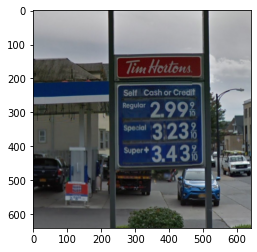

In [17]:
img_idx  = 1
img_file = f'../example-images/example_{img_idx}.png'
gt_file  = f'../example-images/example_{img_idx}.csv' 
image    = cv2.imread(img_file)
plt.imshow(cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB))
plt.show()

### Step 3: From the Image, Predict the Sign-Level Mask

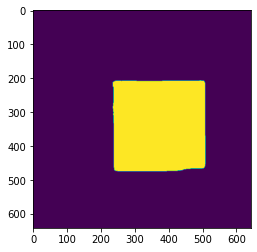

In [18]:
mask = get_mask(image, sign_model)
plt.imshow(mask)
plt.show()

### Step 4: From the Predicted Sign-Level Mask, Extract  the Border

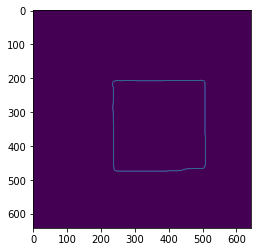

In [19]:
border = get_border(mask)
plt.imshow(border)
plt.show()

### Step 5: Using the Extracted Border, Detect the Hough Lines

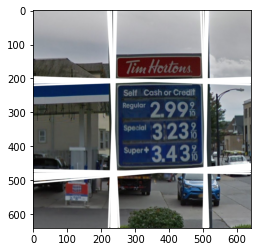

In [20]:
line_df, line_image = get_lines(border, image.copy())
plt.imshow(cv2.cvtColor(line_image.copy(), cv2.COLOR_BGR2RGB))
plt.show()   

### Step 6: From the Detected Hough lines, Obtain the Points of Intersection

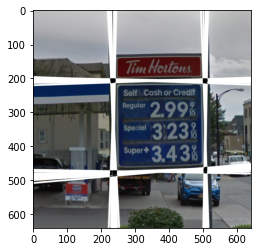

In [21]:
intersection_df, intersection_image = get_intersections(line_df, line_image)
plt.imshow(cv2.cvtColor(intersection_image.copy(), cv2.COLOR_BGR2RGB))
plt.show()  

### Step 7: From the Points of Intersection, Obtain the Sign-Level Corners

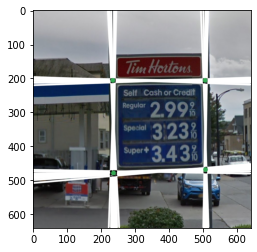

In [22]:
src_pts, corners_image = get_corners(intersection_df, intersection_image)
plt.imshow(cv2.cvtColor(corners_image.copy(), cv2.COLOR_BGR2RGB))
plt.show() 

### Step 8: Keystone Correct the Sign using Four Corners

This steep generates a sign-level, perspective-corrected image.

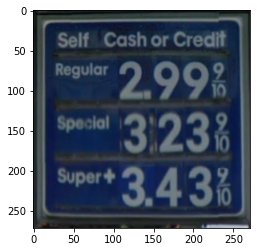

In [23]:
keystone_image = get_KS(src_pts, image.copy())
plt.imshow(cv2.cvtColor(keystone_image.copy(), cv2.COLOR_BGR2RGB))
plt.show() 

### Step 9: Using the Sign-Level Image, Extract all Prices

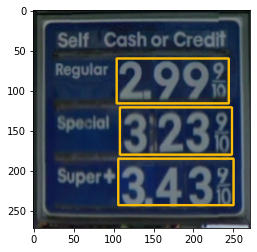

In [24]:
where_prices, price_image = price_level(keystone_image.copy(), price_model)
plt.imshow(cv2.cvtColor(price_image.copy(), cv2.COLOR_BGR2RGB))
plt.show() 

### Step 10: Using the Sign-Level Image, Extract all Labels

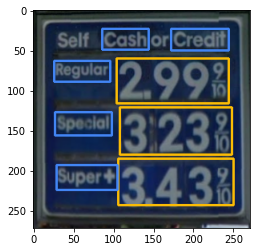

In [25]:
where_labels, label_image = label_level(keystone_image.copy(), label_model, price_image)
plt.imshow(cv2.cvtColor(label_image.copy(), cv2.COLOR_BGR2RGB))
plt.show() 

### Step 11: Using all Extracted Price-Level Images, Detect all Digits

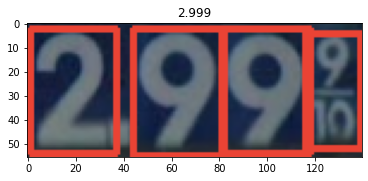

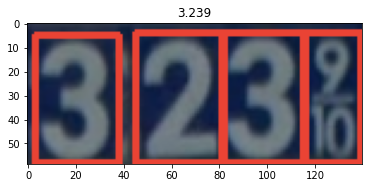

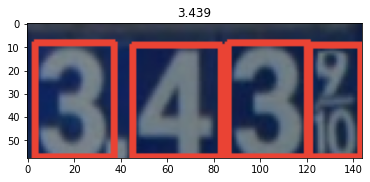

In [26]:
prices = []
for price in where_prices:
    current_price, price_image = read_digits(keystone_image.copy()[price[1]:price[3], price[0]:price[2]] , digit_model )
    prices.append(( price[0], price[1], price[2], price[3], current_price))        
    plt.imshow(cv2.cvtColor(price_image.copy(), cv2.COLOR_BGR2RGB))
    plt.title(str(current_price))
    plt.show() 

### Step 12: Using all Extracted Prices & Labels, Associate & Generate Final Prediction

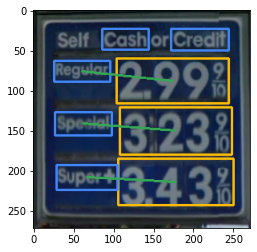

Complete Predicted Dataframe:
   Price      Grade Cash/Credit
0  2.999    Regular        Both
1  3.239  Mid-Grade        Both
2  3.439    Premium        Both


In [27]:
df , associate_image = associate(prices, where_labels, label_image)
plt.imshow(cv2.cvtColor(associate_image.copy(), cv2.COLOR_BGR2RGB))
plt.show() 
print(f'Complete Predicted Dataframe:\n{df}')

### Final Step: Evaluate Performance with Ground Truth Annotation

In [28]:
df_groundtruth = pd.read_csv(gt_file)
df_groundtruth['Price'] = df_groundtruth['Price'].round(3)
print(f'All-or-Nothing Accuracy (ANA): {ANA(df, df_groundtruth)}\n\nPredicted:\n{df}\n\nGround Truth:\n{df_groundtruth}')

All-or-Nothing Accuracy (ANA): 1.0

Predicted:
   Price      Grade Cash/Credit
0  2.999    Regular        Both
1  3.239  Mid-Grade        Both
2  3.439    Premium        Both

Ground Truth:
   Price      Grade Cash/Credit
0  2.999    Regular        Both
1  3.239  Mid-Grade        Both
2  3.439    Premium        Both


### Thats all Folks!